# IA317: Large-scale machine learning
# Tree search

In this lab, you will learn to work with [kd-trees](https://en.wikipedia.org/wiki/K-d_tree), in particular to build the graph of nearest neighbors.<br>
You will find below a function to build a kd-tree and to find the nearest neighbor of some target using this data structure.

## Instructions

Please provide short answers to the questions at the bottom of the notebook. Most involve Python coding. Add as many cells as necessary (code and text). You might test your code using synthetic data.

Before uploading your notebook on [eCampus](https://ecampus.paris-saclay.fr/course/view.php?id=18426), please:
* Delete all useless cells (tests, etc.)
* Check that **your code is running and does not produce any errors**. You might restart the kernel and run all cells at the end of the lab to check that this is indeed the case. 
* Keep the outputs.

The deadline is **Thursday, December 18th (midnight).**

## Import

In [1]:
import numpy as np
from scipy.sparse import  csr_matrix
import matplotlib.pyplot as plt
import pandas as pd
import time
from scipy.sparse.csgraph import connected_components
from math import sin, cos, sqrt, atan2
from sklearn.neighbors import BallTree
from collections import Counter

## Synthetic data

In [2]:
# Standard Gaussian model
X_synthetic = np.random.normal(size = (100,2))

## Real data

We will use a dataset providing the GPS coordinates of the ~13,000 largest cities of the world. For simplicity, we will use the Euclidean distance on the world map, with coordinates = (longitude, latitude).

In [3]:
# First download the file
cities = pd.read_csv('data_tp/worldcities.csv')

In [4]:
cities.head()

,city,city_ascii,lat,lng,country,iso2,iso3,admin_name,capital,population,id
0,Malishevë,Malisheve,42.4822,20.7458,Kosovo,XK,XKS,Malishevë,admin,NaN,1901597212
1,Prizren,Prizren,42.2139,20.7397,Kosovo,XK,XKS,Prizren,admin,NaN,1901360309
2,Zubin Potok,Zubin Potok,42.9144,20.6897,Kosovo,XK,XKS,Zubin Potok,admin,NaN,1901608808
3,Kamenicë,Kamenice,42.5781,21.5803,Kosovo,XK,XKS,Kamenicë,admin,NaN,1901851592
4,Viti,Viti,42.3214,21.3583,Kosovo,XK,XKS,Viti,admin,NaN,1901328795


In [5]:
names = list(cities['city'])
admin_names = list(cities['admin_name'])
lat = list(cities['lat'])
long = list(cities['lng'])

In [6]:
X = np.vstack((long,lat)).T

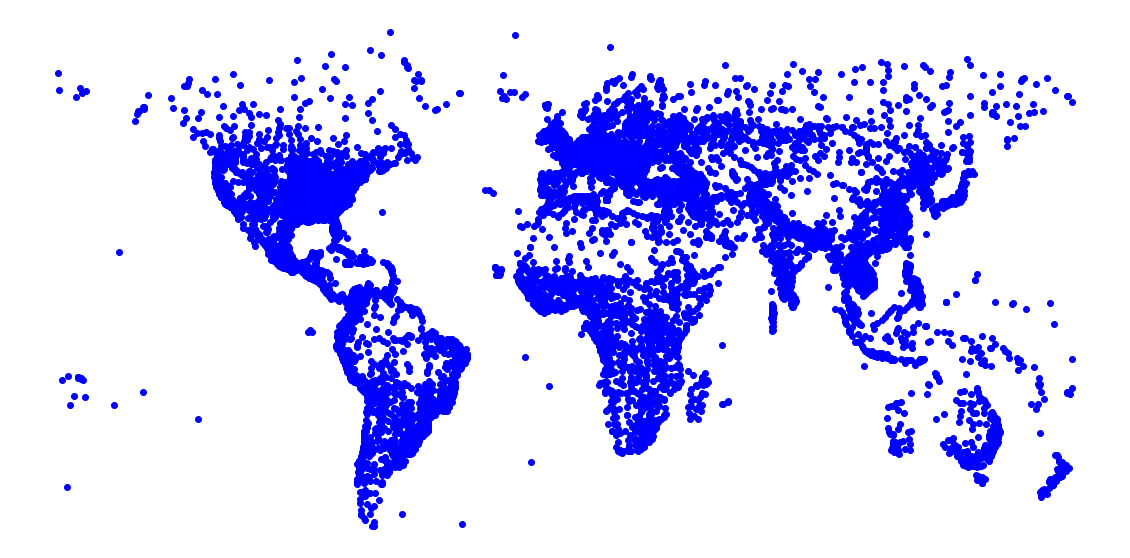

In [7]:
plt.figure(figsize = (20,10))
_ = plt.scatter(X[:,0], X[:,1], c='b')
_ = plt.axis('off')

## Kd trees

In [8]:
class KD_Tree:
    def __init__(self, index, ancestor, mins, maxs):
        self.index = index
        self.ancestor = ancestor
        self.mins = mins
        self.maxs = maxs
        self.direction = None        
        self.pivot = None
        self.left = None
        self.right = None

In [9]:
def split(X, index, method):
    '''Split method (max spread or max variance)
    
    Parameters
    ----------
    X : np.ndarray 
        Data (n_samples, n_features)
    index : np.ndarray
        Sample indices, within range(n_samples)
    method : str, 'maxspread' or 'maxvariance'
        Method 
        
    Returns
    -------
    k : int
        Direction, in range(n_features)
    i : int
        Pivot, in range(n_samples)
    '''
    if method == 'maxspread':
        # max spread
        mins = np.min(X[index], axis = 0)
        maxs = np.max(X[index], axis = 0)
        k = np.argmax(maxs - mins)
        middle = (maxs[k] + mins[k]) / 2
        i = index[np.argmin(np.abs(X[index,k] - middle))]
    else:
        # max variance
        k = np.argmax(np.std(X[index], axis = 0))
        i = index[np.argsort(X[index,k])[len(index) // 2]]
    return k, i

In [10]:
def build_kd_tree(X, index = None, ancestor = None, mins = None, maxs = None, leaf_size = 30, method = 'maxspread'):
    '''Build the kd-tree from data.
    
    Parameters
    ----------
    X : np.ndarray 
        Data (n_samples, n_features)
    index : np.ndarray or None
        Sample indices, within range(n_samples)
    ancestor : KD_Tree or None
        Ancestor of the current node
    mins : np.ndarray or None
        Min values of the rectangle, shape (n_features,)
    maxs : np.ndarray
        Max values of the rectangle, shape (n_features,)
    leaf_size : int
        Leaf size of the kd-tree 
    method : str, 'maxspread' or 'maxvariance'
        Split method 
        
    Returns
    -------
    tree : KD_Tree
        kd-tree
    '''
    if index is None:
        index = np.arange(X.shape[0])
        mins = np.min(X[index], axis = 0)
        maxs = np.max(X[index], axis = 0)
    tree = KD_Tree(index, ancestor, mins, maxs)
    if len(index) > leaf_size:
        k,i = split(X, index, method)
        tree.direction, tree.pivot = k, i
        index = np.array(list(set(index) - {i}))
        index_left = index[np.where(X[index,k] <= X[i,k])[0]]
        maxs_ = maxs.copy()
        maxs_[k] = X[i,k]
        tree.left = build_kd_tree(X, index_left, tree, mins, maxs_, leaf_size, method)
        index_right = index[np.where(X[index,k] > X[i,k])[0]]
        mins_ = mins.copy()
        mins_[k] = X[i,k]        
        tree.right = build_kd_tree(X, index_right, tree, mins_, maxs, leaf_size, method)
    return tree

In [11]:
def search_leaf(x, X, tree):
    '''Search the leaf node of the kd-tree given some target.
    
    Parameters
    ----------
    x : np.ndarray
        Target (n_features,)
    X : np.ndarray 
        Data (n_samples, n_features)
    tree : KD_Tree
        kd-tree
        
    Returns
    -------
    tree : KD_Tree
        Leaf node
    '''
    if tree.pivot is not None:
        k = tree.direction
        i = tree.pivot
        if x[k] <= X[i,k]:
            return search_leaf(x, X, tree.left)
        else:
            return search_leaf(x, X, tree.right)
    else:
        return tree

In [12]:
def nn_search_kd_tree(x, X, tree):
    '''Search the nearest neighbor of some target.
    
    Parameters
    ----------
    x : np.ndarray
        Target (n_features,)
    X : np.ndarray 
        Data (n_samples, n_features)
    tree : KD_Tree
        kd-tree
        
    Returns
    -------
    nn : int
        Index of the nearest neighbor
    '''
    node = search_leaf(x, X, tree)
    index = node.index
    nn = None
    if len(index):
        nn = index[np.argmin(np.linalg.norm(X[index] - x, axis = 1))]
        dist = np.linalg.norm(X[nn] - x)
    
    while node.ancestor is not None:
        previous = node
        node = node.ancestor
        if nn is None or np.linalg.norm(X[node.pivot] - x) < dist:
            nn = node.pivot
            dist = np.linalg.norm(X[nn] - x)
        if previous == node.left:
            tree_ = node.right
        else:
            tree_ = node.left
        if tree_ is not None and len(tree_.index):
            explore = False
            if not tree_.pivot:
                explore = True
            else:
                y = np.maximum(tree_.mins, np.minimum(tree_.maxs, x))
                explore = (np.linalg.norm(x - y) < dist)
            if explore:
                ancestor = tree_.ancestor
                tree_.ancestor = None
                nn_ = nn_search_kd_tree(x, X, tree_)
                dist_ = np.linalg.norm(X[nn_] - x)
                if dist_ < dist:
                    nn, dist = nn_, dist_
                tree_.ancestor = ancestor
    return nn

## Questions

1. What is the closest city from the [Null Island](https://fr.wikipedia.org/wiki/Null_Island) (provide the name)?

In [13]:
KD_tree = build_kd_tree(X)

In [14]:
null_island = [0,0]
index = nn_search_kd_tree(null_island, X, KD_tree)
cities.iloc[index]

city             Sekondi
city_ascii       Sekondi
lat               4.9433
lng               -1.704
country            Ghana
iso2                  GH
iso3                 GHA
admin_name       Western
capital            admin
population        286248
id            1288186231
Name: 7065, dtype: object

2. What are the 10 closest cities from Paris (provide the names)?<br>
Choose the true Paris :-)

In [15]:
index_Paris = np.where((cities['city'] == 'Paris') & (cities['country'] == 'France'))[0][0]
latlng_Paris = [long[index_Paris],lat[index_Paris]]

In [16]:
def euclidean_distance(X,x):
    
    if len(np.array(X).shape) == 1:
        axis = 0
    else:
        axis = 1
    
    return np.linalg.norm(X - x, axis=axis)

def knn_search_KD_tree(x, X, tree, k, distance_function=euclidean_distance):
    
    node  = search_leaf(x, X, tree)
    index = node.index
    k_index = []
    if len(index):
        k_index = index[np.argsort(distance_function(X[index],x))[:k]]
        dist    = distance_function(X[k_index[-1]],x)

    while node.ancestor is not None:
        previous = node
        node     = node.ancestor
        if k_index is None or distance_function(X[node.pivot],x) < dist:

            index_cat = np.concatenate(([node.pivot], index))
            k_index   = index_cat[np.argsort(distance_function(X[index_cat],x))[:k]]
            dist      = max(distance_function(X[k_index],x))

        if previous == node.left:
            tree_ = node.right
        else:
            tree_ = node.left

        if tree_ is not None and len(tree_.index):
            explore = False
            if not tree_.pivot:
                explore = True
            else:
                y = np.maximum(tree_.mins, np.minimum(tree_.maxs, x))
                explore = (distance_function(x,y) < dist)
            if explore:
                ancestor       = tree_.ancestor
                tree_.ancestor = None
                k_index_       = knn_search_KD_tree(x, X, tree_, k, distance_function)
                dist_          = min(distance_function(X[k_index_],x))
                if dist_ < dist:
                    index_cat      = np.concatenate((k_index, k_index_))
                    k_index        = index_cat[np.argsort(distance_function(X[index_cat],x))[:k]]
                    dist           = max(distance_function(X[k_index],x))
                    tree_.ancestor = ancestor
            
    return k_index

In [17]:
k_index = knn_search_KD_tree(latlng_Paris, X, KD_tree, 10)
cities.iloc[k_index]

,city,city_ascii,lat,lng,country,iso2,iso3,admin_name,capital,population,id
6735,Paris,Paris,48.8667,2.3333,France,FR,FRA,Île-de-France,primary,9904000.0,1250015082
6768,Versailles,Versailles,48.8005,2.1333,France,FR,FRA,Île-de-France,minor,85416.0,1250143827
6769,Melun,Melun,48.5333,2.6666,France,FR,FRA,Île-de-France,minor,249432.0,1250913458
6746,Amiens,Amiens,49.9004,2.3000,France,FR,FRA,Hauts-de-France,minor,143086.0,1250794759
6734,Orléans,Orleans,47.9004,1.9000,France,FR,FRA,Centre-Val de Loire,admin,217301.0,1250441405
6745,Rouen,Rouen,49.4304,1.0800,France,FR,FRA,Normandie,admin,532559.0,1250372069
6762,Arras,Arras,50.2833,2.7833,France,FR,FRA,Hauts-de-France,minor,64165.0,1250447540
6765,Auxerre,Auxerre,47.8004,3.5666,France,FR,FRA,Bourgogne-Franche-Comté,minor,41516.0,1250482884
6755,Dieppe,Dieppe,49.9337,1.0833,France,FR,FRA,Normandie,NaN,42461.0,1250006284
6752,Reims,Reims,49.2504,4.0300,France,FR,FRA,Grand Est,NaN,196565.0,1250608730


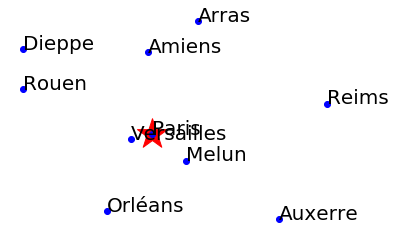

In [18]:
plt.scatter(latlng_Paris[0], latlng_Paris[1],marker='*',c='r',s=1000)
plt.scatter(X[k_index,0], X[k_index,1], c='b')
for k in k_index:
    plt.text(X[k,0], X[k,1], names[k], fontsize=20) 
plt.axis('off')
plt.show()

3. Compare the previous search time to a brute force approach (with default leaf size = 30).

In [19]:
def brute_force(x, X, tree, k):
    k_index = np.argsort(np.linalg.norm(X - x, axis=1))[:k]
    return k_index

In [20]:
%timeit knn_search_KD_tree(latlng_Paris, X, KD_tree, 10)
%timeit brute_force(latlng_Paris, X, KD_tree, 10)    

1.15 ms ± 327 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
1.21 ms ± 147 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


4. Do the same comparison for synthetic data (with $10^6$ samples for instance). Comment.

In [21]:
from random import randint

X_synthetic = np.random.normal(size = (int(1e6),2))
x_synthetic = X_synthetic[randint(0, int(1e6)),:]
synthetic_tree = build_kd_tree(X_synthetic)

In [22]:
%timeit knn_search_KD_tree(x_synthetic, X_synthetic, synthetic_tree, 10)
%timeit brute_force(x_synthetic, X_synthetic, synthetic_tree, 10)    

1.98 ms ± 189 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
252 ms ± 22.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


<font color="blue"> The brute force is much slower than the KD tree </font>

5. What is the depth of the leaf node containing Paris in the kd-tree? What is the total number of samples considered in the search?<br>
Test various leaf sizes (e.g., 1, 10, 100, ...) and comment.

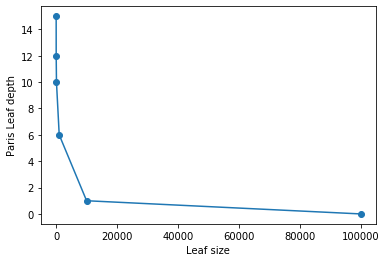

In [23]:
leaf_sizes = [1, 10, 100, 1000, 10000, 100000]
depths = []

for leaf_size in leaf_sizes:
    current_tree = build_kd_tree(X, leaf_size=leaf_size)
    depth = 0
    paris_leaf = search_leaf(latlng_Paris, X, current_tree)
    while paris_leaf.ancestor is not None:
        paris_leaf = paris_leaf.ancestor
        depth      += 1
    depths.append(depth)

plt.plot(leaf_sizes, depths,'o-')
plt.xlabel('Leaf size')
plt.ylabel('Paris Leaf depth')
plt.show()

<font color="blue"> As the leaf size increases, the Paris depth decreases. It makes sense because if the leaf size increase it means that there is less leaf in the tree and then the tree has less depth.  </font>

6. Do the same experiment with a ball tree.

In [24]:
ball_tree = BallTree(X_synthetic)

%timeit ball_tree.query(x_synthetic.reshape(1,-1), k=10) 
%timeit brute_force(x_synthetic, X_synthetic, ball_tree, 10)  

281 µs ± 18.8 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
236 ms ± 20.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


<font color="blue"> We note that the ball tree is faster than the KD tree (more compact in high dimensions).  </font>

7. Build the graph of 3-nearest neighbors. You must return the adjacency matrix of the graph in the sparse format of your choice. How many connected components are there in this graph, considered as undirected (check [this](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csgraph.connected_components.html))? Show the 3 largest connected components on the map. 

In [25]:
def my_kneighbors_graph(X, tree, k, distance_function):
    n = X.shape[0]
    A = np.zeros((n,n))
    for i in np.arange(0,n):
        knn_index = knn_search_KD_tree(X[i,:], X, tree, k, distance_function)[1:]
        A[i,knn_index] = 1
        
    return csr_matrix(A)

In [26]:
A = my_kneighbors_graph(X, KD_tree, 4, euclidean_distance)
#from sklearn.neighbors import kneighbors_graph
#A = kneighbors_graph(X, 4, include_self=True)

n_components, labels = connected_components(A, directed=False, return_labels=True)
print('There is ',n_components,'connected components.')

There is  258 connected components.


In [27]:
# get the 3 most common labels
labels_3 = np.array(Counter(labels).most_common(3))[:,0]

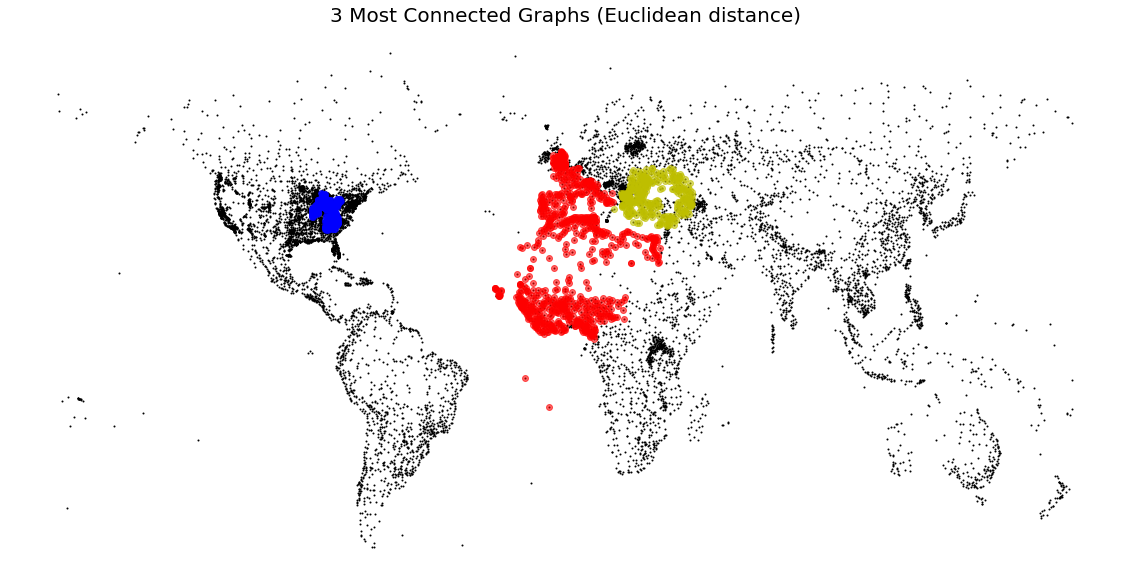

In [28]:
plt.figure(figsize=(20,10))
colors = ['r','b','y']

plt.scatter(X[:,0], X[:,1], c='k', s = 1)
for i in range(3): 
    ind = np.where(labels == labels_3[i])[0] # get points that are in this label
    plt.plot(X[ind,0],X[ind,1], 'o', color = colors[i], alpha = 0.6) # plot 3 lines of point j j

plt.axis('off')
plt.title('3 Most Connected Graphs (Euclidean distance)',fontsize=20)
plt.show()

8. (optional) Do the same with the actual distances between cities!

<font color="blue"> Because the Earth is round, cities near to the earth poles can have very different longitude but be close to each other. So I convert latitude and longitude in actual distances with trigonometric formulas. </font>

In [29]:
def earth_distance(X,x):
    
    if len(np.array(X).shape) == 1:
        n = 1
        X = np.array(X).reshape(1,2)
    else:
        n = X.shape[0]

    dist     = np.zeros(n)
    E_radius = 6371.0 # km
    X_rad    = np.radians(X)
    x_rad    = np.radians(x)
    
    for i in np.arange(0,n):
        lat_1, lon_1 = x_rad[1], x_rad[0]
        lat_2, lon_2 = X_rad[i,1], X_rad[i,0]
        d_lon   = lon_2 - lon_1 
        d_lat   = lat_2 - lat_1
        a       = sin(d_lat / 2)**2 + cos(lat_1) * cos(lat_2) * sin(d_lon / 2)**2
        c       = 2 * atan2(sqrt(a), sqrt(1 - a))
        dist[i] = E_radius * c

    return dist

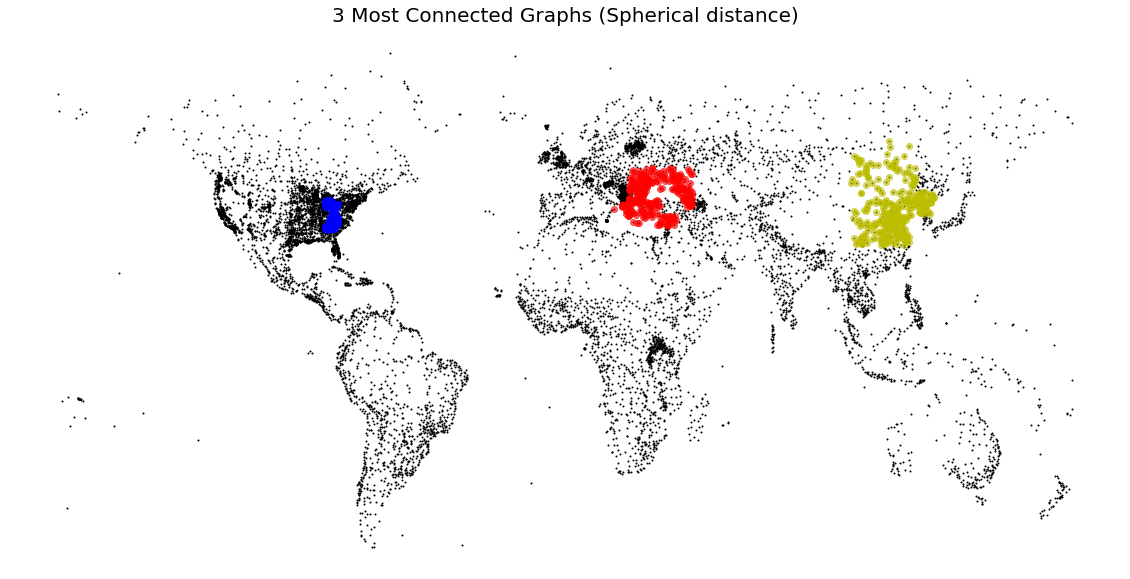

In [30]:
A = my_kneighbors_graph(X, KD_tree, 4, earth_distance)
n_components, labels = connected_components(A, directed=False, return_labels=True)
labels_3 = np.array(Counter(labels).most_common(3))[:,0]

plt.figure(figsize=(20,10))
colors = ['r','b','y']

plt.scatter(X[:,0], X[:,1], c='k', s = 1)
for i in range(3): 
    ind = np.where(labels == labels_3[i])[0] # get points that are in this label
    plt.plot(X[ind,0],X[ind,1], 'o', color = colors[i], alpha = 0.6) # plot 3 lines of point j

plt.axis('off')
plt.title('3 Most Connected Graphs (Spherical distance)',fontsize=20)
plt.show()